# Mathematical Optimization Model

### Indexes / Index Sets
- $t \in T$ : Set of time periods

### Parameters
- $P_{PV}(t)$ : Energy produced by the PV system at time $t$ [kWh]
- $\lambda(t)$ : Electricity price at time $t$ [\$/kWh]
- $\eta_{ch}$ : Charging efficiency of the battery
- $\eta_{dis}$ : Discharging efficiency of the battery
- $C_{max}$ : Maximum energy capacity of the battery [kWh]
- $P_{ch, max}$ : Maximum charging power of the battery [kW]
- $P_{dis, max}$ : Maximum discharging power of the battery [kW]
- $SOC_{min}$ : Minimum state of charge (SOC) of the battery [kWh]
- $SOC_{max}$ : Maximum state of charge (SOC) of the battery [kWh]
- $SOC_{0}$ : Initial state of charge of the battery [kWh]

### Decision Variables
- $P_{sell}(t)$ : Energy sold directly from production to the grid at time $t$ [kWh]
- $P_{ch}(t)$ : Energy used to charge the battery at time $t$, multiply by $\eta_{ch}$ to get the actual increase in charge [kWh]
- $P_{dis}(t)$ : Energy discharged from the battery at time $t$, mutiply by $\eta_{dis}$ to get the actual energy that is converted [kWh]
- $SOC(t)$ : State of charge of the battery at time $t$ [kWh]

### Objective Function
Maximize total revenue over the time horizon $T$:
$$
\max \sum_{t \in T} \lambda(t) \cdot (P_{sell}(t) + \eta_{dis}P_{dis}(t)) \tag{1}
$$

### Constraints

#### 1. Energy balance constraint:
At each time period $t$, the produced energy is either sold to the grid or used to charge the battery:
$$
P_{PV}(t) = P_{sell}(t) + P_{ch}(t) \tag{2}
$$



#### 2. Battery charging and discharging:
The battery can either charge or discharge at any given time:
$$
P_{ch}(t) \geq 0, \quad P_{dis}(t) \geq 0 \tag{3}
$$
$$
P_{ch}(t) \cdot P_{dis}(t) = 0, \quad \forall t \in T \tag{4}
$$

#### 3. Battery state of charge (SOC) dynamics:
The state of charge evolves based on charging and discharging actions:
$$
SOC(t) = SOC(t-1) + \eta_{ch} \cdot P_{ch}(t) - P_{dis}(t), \quad \forall t \in T - {0}  \tag{5}
$$

#### 4. Battery operational limits:
The state of charge should always remain within the battery's capacity:
$$
SOC_{min} \leq SOC(t) \leq SOC_{max}, \quad \forall t \in T \tag{6}
$$

#### 5. Charging and discharging power limits:
The charging and discharging power should respect the battery's capabilities:
$$
0 \leq P_{ch}(t) \leq P_{ch, max}, \quad 0 \leq P_{dis}(t) \leq P_{dis, max}, \quad \forall t \in T \tag{7}
$$

#### 6. Initial state of charge:
The state of charge at the initial time is given:
$$
SOC(0) = SOC_0 \tag{8}
$$

### Summary
This mathematical formulation aims to optimize the revenue generated by selling energy to the grid, considering the constraints of battery operation, production from the PV system, and the known electricity prices. The decision variables determine how the PV energy is allocated to charging the battery, discharging, or selling it directly to the grid.


In [3]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt


# Define the model
model = gp.Model("BESS_PV_Optimization")

# Parameters (example data)
T = 24  # Time horizon (24 hours)
P_PV = [5, 4, 3, 2, 1, 0, 0, 0, 2, 4, 6, 8, 10, 8, 6, 4, 2, 0, 0, 0, 2, 4, 5, 6]  # PV production curve [kWh]
lambda_price = [30, 28, 27, 25, 22, 20, 15, 10, 15, 20, 25, 30, 35, 40, 35, 30, 25, 20, 18, 15, 20, 25, 28, 30]  # Electricity prices [$/kWh]
eta_ch = 1  # Charging efficiency
eta_dis = 1  # Discharging efficiency
C_max = 20  # Max battery capacity [kWh]
P_ch_max = 5  # Max charging power [kW]
P_dis_max = 5  # Max discharging power [kW]
SOC_min = 0  # Minimum SOC [kWh]
SOC_max = C_max  # Maximum SOC [kWh]
SOC_0 = 0  # Initial state of charge [kWh]

# Decision variables
P_sell = model.addVars(T, lb=0, name="P_sell")  # Energy sold to the grid
P_ch = model.addVars(T, lb=0, ub=P_ch_max, name="P_ch")  # Energy used to charge the battery
P_dis = model.addVars(T, lb=0, ub=P_dis_max, name="P_dis")  # Energy discharged from the battery
SOC = model.addVars(T, lb=SOC_min, ub=SOC_max, name="SOC")  # State of charge of the battery

# Objective: Maximize total revenue from selling energy to the grid
model.setObjective(gp.quicksum(lambda_price[t] * (P_sell[t] + eta_ch * P_ch[t]) for t in range(T)), GRB.MAXIMIZE)

# Constraints

# 1. Energy balance constraint: PV production is either sold or used to charge the battery
for t in range(T):
    model.addConstr(P_PV[t] == P_sell[t] + P_ch[t], name=f"Energy_balance_{t}")

# 2. Battery charging and discharging constraint: No simultaneous charge and discharge
for t in range(T):
    model.addConstr(P_ch[t] * P_dis[t] == 0, name=f"No_simultaneous_charge_discharge_{t}")

# 3. Battery state of charge dynamics
model.addConstr(SOC[0] == SOC_0, name="Initial_SOC")  # Initial state of charge

for t in range(1, T):
    model.addConstr(SOC[t] == SOC[t - 1] + eta_ch * P_ch[t] - P_dis[t] / eta_dis, name=f"SOC_dynamics_{t}")

# 4. Charging and discharging power limits are already set with bounds in decision variables

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print(f"Optimal revenue: {model.objVal}")
    for t in range(T):
        print(f"Hour {t}: P_sell = {P_sell[t].x:.2f}, P_ch = {P_ch[t].x:.2f}, P_dis = {P_dis[t].x:.2f}, SOC = {SOC[t].x:.2f}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-27
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 48 rows, 96 columns and 141 nonzeros
Model fingerprint: 0x2439f09f
Model has 24 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+01, 4e+01]
  Bounds range     [5e+00, 2e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 25 rows and 31 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 48 rows and 96 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 2425 

Opti

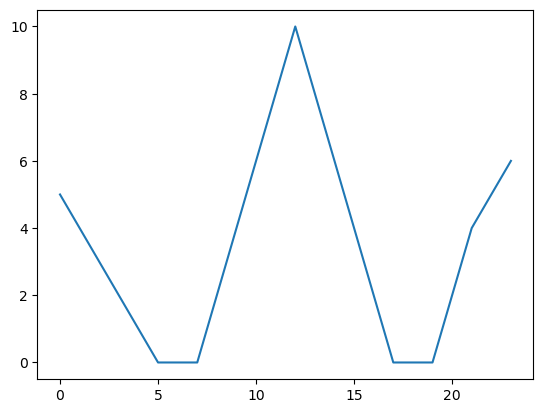

In [4]:
plt.plot(P_PV, label='PV production')

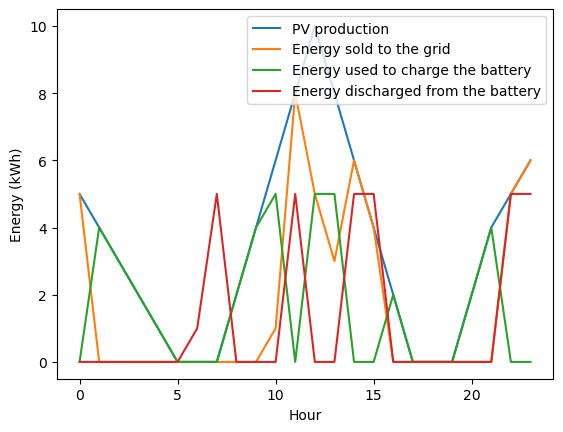

In [5]:
# Print production vs sold vs charged vs discharged


plt.figure()
plt.plot(P_PV, label='PV production')
plt.plot([P_sell[t].x for t in range(T)], label='Energy sold to the grid')
plt.plot([P_ch[t].x for t in range(T)], label='Energy used to charge the battery')
plt.plot([P_dis[t].x for t in range(T)], label='Energy discharged from the battery')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend()


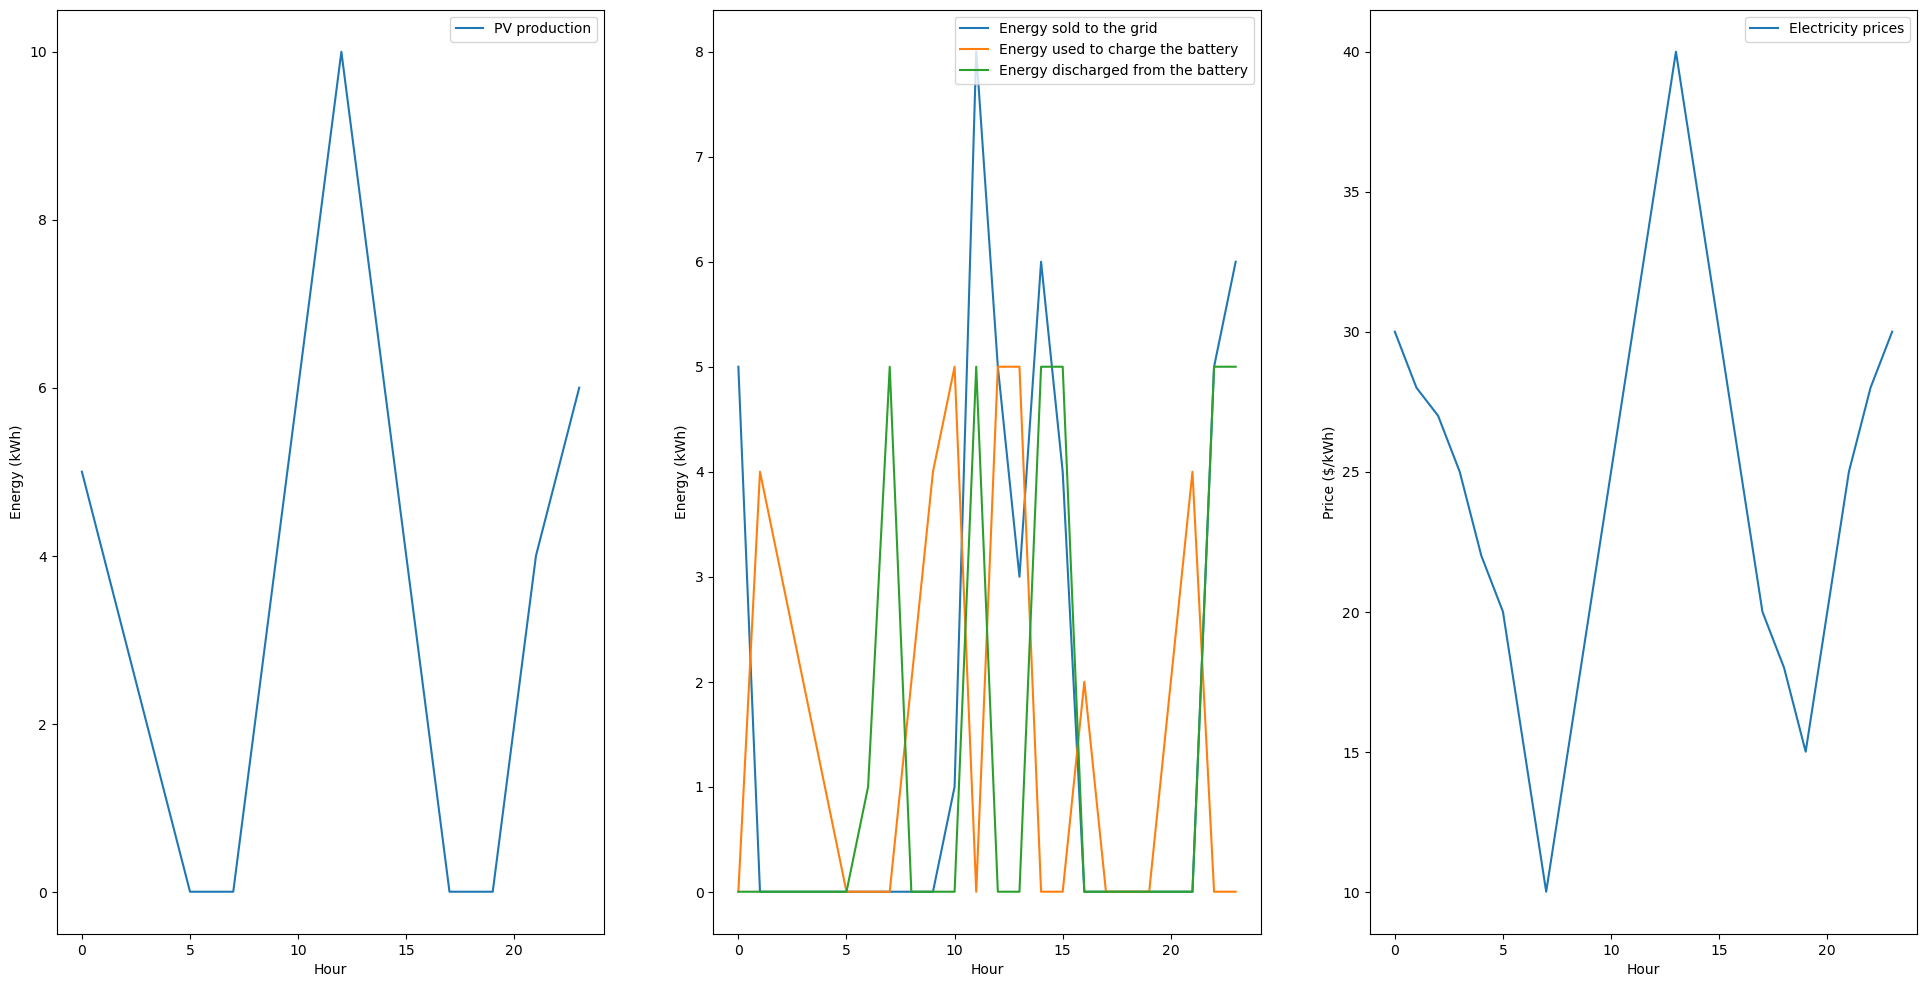

In [6]:
# print enery produced in the left plot and energy sold, charged and discharged in the right plot
plt.figure(figsize=(24, 12))
plt.subplot(1, 3, 1)
plt.plot(P_PV, label='PV production')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot([P_sell[t].x for t in range(T)], label='Energy sold to the grid')
plt.plot([P_ch[t].x for t in range(T)], label='Energy used to charge the battery')
plt.plot([P_dis[t].x for t in range(T)], label='Energy discharged from the battery')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(lambda_price, label='Electricity prices')
plt.xlabel('Hour')
plt.ylabel('Price ($/kWh)')
plt.legend()



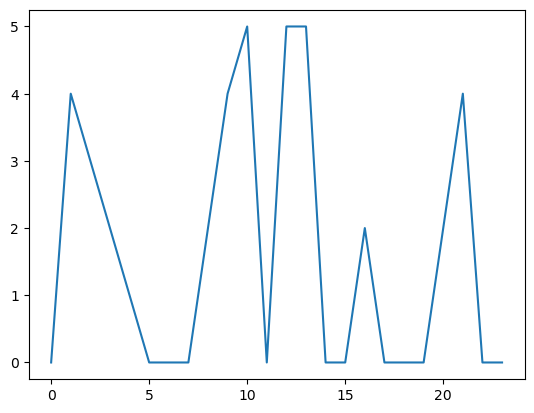

In [7]:
plt.plot([P_ch[t].x for t in range(T)], label='Energy used to charge the battery')

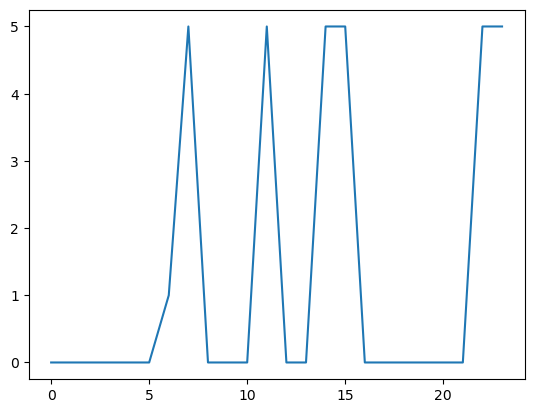

In [8]:
plt.plot([P_dis[t].x for t in range(T)], label='Energy discharged from the battery')

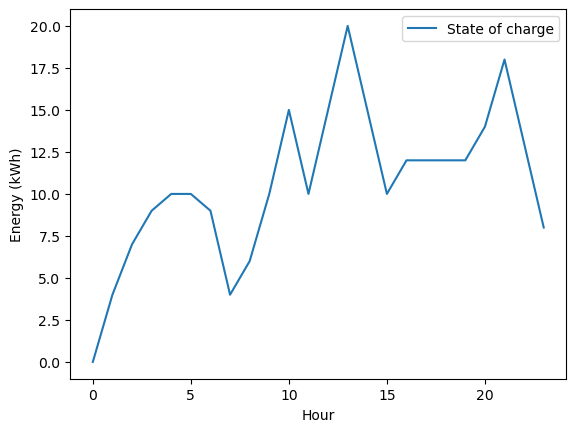

In [9]:
# Print the state of charge
plt.figure()
plt.plot([SOC[t].x for t in range(T)], label='State of charge')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend()

## With 2023 electricity prices and 2016 capacity factor

In [10]:
import pandas as pd
import os
DATA_FOLDER = os.path.join(os.getcwd(), '..', 'data', 'processed')

In [11]:
capacity_peak = 30 # MW
electricity_prices = pd.read_csv(os.path.join(DATA_FOLDER,'electricity_prices_spain_2023.csv'))
capacity_factors = pd.read_csv(os.path.join(DATA_FOLDER,'merra_spain_2016.csv'))

In [12]:
capacity_factors_list = capacity_factors['Capacity factor'].to_numpy()
electricity_prices_list = electricity_prices['Price (EUR/MWhe)'].to_numpy()
production_pv = capacity_peak * capacity_factors_list

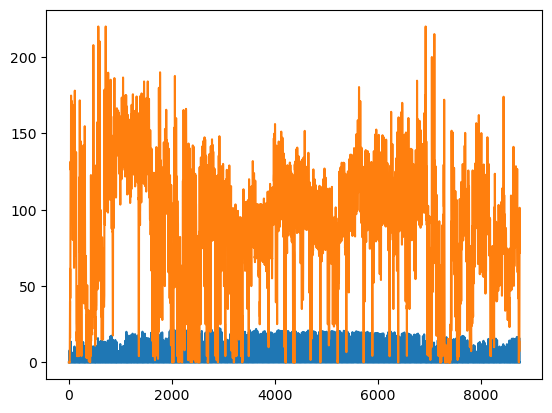

In [13]:
plt.plot(production_pv, label='PV production')
plt.plot(electricity_prices_list, label='Electricity prices')

In [14]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt


# Define the model
model = gp.Model("BESS_PV_Optimization")

# Parameters (example data)
T = len(production_pv)  # Time horizon (24 hours)
P_PV = production_pv  # PV production curve [MWh]
lambda_price = electricity_prices_list # Electricity prices [£/MWh]
eta_ch = 1  # Charging efficiency
eta_dis = 1  # Discharging efficiency
C_max = 20  # Max battery capacity [MWh]
P_ch_max = 0.5 # Max charging power [MW]
P_dis_max = 500  # Max discharging power [MW]
SOC_min = 0  # Minimum SOC [MWh]
SOC_max = C_max  # Maximum SOC [MWh]
SOC_0 = 0  # Initial state of charge [MWh]

# Decision variables
P_sell = model.addVars(T, lb=0, name="P_sell")  # Energy sold to the grid
P_ch = model.addVars(T, lb=0, ub=P_ch_max, name="P_ch")  # Energy used to charge the battery
P_dis = model.addVars(T, lb=0, ub=P_dis_max, name="P_dis")  # Energy discharged from the battery
SOC = model.addVars(T, lb=SOC_min, ub=SOC_max, name="SOC")  # State of charge of the battery

# Objective: Maximize total revenue from selling energy to the grid
model.setObjective(gp.quicksum(lambda_price[t] * (P_sell[t] + eta_dis * P_dis[t]) for t in range(T)), GRB.MAXIMIZE)

# Constraints

# 1. Energy balance constraint: PV production is either sold or used to charge the battery
for t in range(T):
    model.addConstr(P_PV[t] == P_sell[t] + P_ch[t], name=f"Energy_balance_{t}")

# 2. Battery charging and discharging constraint: No simultaneous charge and discharge
for t in range(T):
    model.addConstr(P_ch[t] * P_dis[t] == 0, name=f"No_simultaneous_charge_discharge_{t}")

# 3. Battery state of charge dynamics
model.addConstr(SOC[0] == SOC_0, name="Initial_SOC")  # Initial state of charge

for t in range(1, T):
    model.addConstr(SOC[t] == SOC[t - 1] + eta_ch * P_ch[t] - P_dis[t] / eta_dis, name=f"SOC_dynamics_{t}")

# 4. Charging and discharging power limits are already set with bounds in decision variables

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print(f"Optimal revenue: {model.objVal}")
    for t in range(T):
        print(f"Hour {t}: P_sell = {P_sell[t].x:.2f}, P_ch = {P_ch[t].x:.2f}, P_dis = {P_dis[t].x:.2f}, SOC = {SOC[t].x:.2f}")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17520 rows, 35040 columns and 52557 nonzeros
Model fingerprint: 0xec1de042
Model has 8760 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-02, 2e+02]
  Bounds range     [5e-01, 5e+02]
  RHS range        [3e-02, 2e+01]
Presolve removed 8762 rows and 12963 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 3731 rows and 16788 columns
Presolve time: 0.20s
Presolved: 13789 rows, 18252 columns, 36502 nonzeros
Variable types: 13790 continuous, 4462 integer (4462 binary)
Found heuristic solution: objective 3159956.8999

Root relaxation: objective 3.165035e+06, 1665 iterations, 0.02 seconds (0.01 work units)

    Nodes

In [15]:
print('Optimal revenue: ', model.objVal)
print("Baseline revenue: ", sum(P_PV * lambda_price))

Optimal revenue:  3165035.478100001
Baseline revenue:  3018708.6873000036


In [16]:
print(model.ObjVal / sum(P_PV * lambda_price))

1.048473306290073


In [18]:
# Print number of non-zero values in P_sell, P_ch, P_dis
print("Number of non-zero values in P_sell: ", sum([P_sell[t].x > 0 for t in range(T)]))
print("Number of non-zero values in P_ch: ", sum([P_ch[t].x > 0 for t in range(T)]))
print("Number of non-zero values in P_dis: ", sum([P_dis[t].x > 0 for t in range(T)]))

Number of non-zero values in P_sell:  4238
Number of non-zero values in P_ch:  4438
Number of non-zero values in P_dis:  219


In [19]:
print(SOC)

{0: <gurobi.Var SOC[0] (value 0.0)>, 1: <gurobi.Var SOC[1] (value 0.0)>, 2: <gurobi.Var SOC[2] (value 0.0)>, 3: <gurobi.Var SOC[3] (value 0.0)>, 4: <gurobi.Var SOC[4] (value 0.0)>, 5: <gurobi.Var SOC[5] (value 0.0)>, 6: <gurobi.Var SOC[6] (value 0.0)>, 7: <gurobi.Var SOC[7] (value 0.0)>, 8: <gurobi.Var SOC[8] (value 0.03000000000000469)>, 9: <gurobi.Var SOC[9] (value 0.5300000000000047)>, 10: <gurobi.Var SOC[10] (value 1.0300000000000047)>, 11: <gurobi.Var SOC[11] (value 1.5300000000000047)>, 12: <gurobi.Var SOC[12] (value 2.0300000000000047)>, 13: <gurobi.Var SOC[13] (value 2.5300000000000047)>, 14: <gurobi.Var SOC[14] (value 3.0300000000000047)>, 15: <gurobi.Var SOC[15] (value 3.5300000000000047)>, 16: <gurobi.Var SOC[16] (value 4.030000000000005)>, 17: <gurobi.Var SOC[17] (value 4.480000000000005)>, 18: <gurobi.Var SOC[18] (value 4.480000000000005)>, 19: <gurobi.Var SOC[19] (value 4.480000000000005)>, 20: <gurobi.Var SOC[20] (value 4.480000000000005)>, 21: <gurobi.Var SOC[21] (value

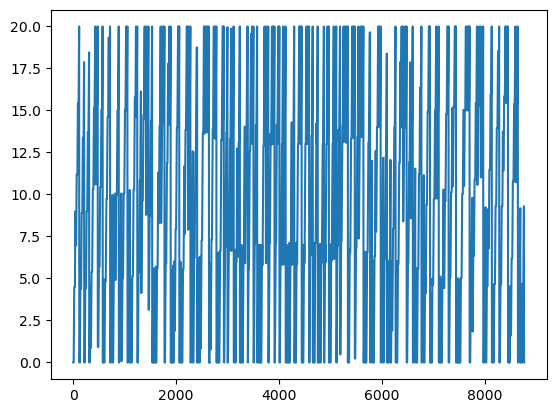

In [20]:
plt.plot([SOC[t].x for t in range(T)], label='State of charge')

In [28]:
total_charging_per_hour_of_the_day = {h: 0 for h in range(24)}
total_discharging_per_hour_of_the_day = {h: 0 for h in range(24)}

for t in range(T):
    total_charging_per_hour_of_the_day[t % 24] += P_ch[t].x
    total_discharging_per_hour_of_the_day[t % 24] += P_dis[t].x
average_charging_per_hour_of_the_day = {h: total_charging_per_hour_of_the_day[h] / (T/24) for h in range(24)}
average_discharging_per_hour_of_the_day = {h: total_discharging_per_hour_of_the_day[h] / (T/24) for h in range(24)}
print(total_charging_per_hour_of_the_day)
print(average_charging_per_hour_of_the_day)

num_days = T / 24
average_electricity_price_per_hour_of_the_day = {h: sum(lambda_price[h + i*24] for i in range(int(num_days))) / num_days for h in range(24)}
print(average_electricity_price_per_hour_of_the_day)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 45.40000000000005, 7: 96.12000000000003, 8: 151.49000000000015, 9: 181.45, 10: 182.5, 11: 182.5, 12: 182.5, 13: 182.5, 14: 182.5, 15: 182.5, 16: 182.0, 17: 177.45999999999992, 18: 118.12000000000003, 19: 65.14000000000001, 20: 3.599999999999999, 21: 0.0, 22: 0.0, 23: 0.0}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.12438356164383575, 7: 0.26334246575342474, 8: 0.4150410958904114, 9: 0.49712328767123287, 10: 0.5, 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.4986301369863014, 17: 0.4861917808219176, 18: 0.3236164383561645, 19: 0.17846575342465756, 20: 0.009863013698630135, 21: 0.0, 22: 0.0, 23: 0.0}
{0: np.float64(90.35432876712323), 1: np.float64(84.99046575342454), 2: np.float64(82.2114246575342), 3: np.float64(80.0821643835616), 4: np.float64(81.0377808219177), 5: np.float64(87.50131506849311), 6: np.float64(96.11964383561643), 7: np.float64(101.22953424657521), 8: np.float64(96.2296164383561), 9: np.float64(83.637095

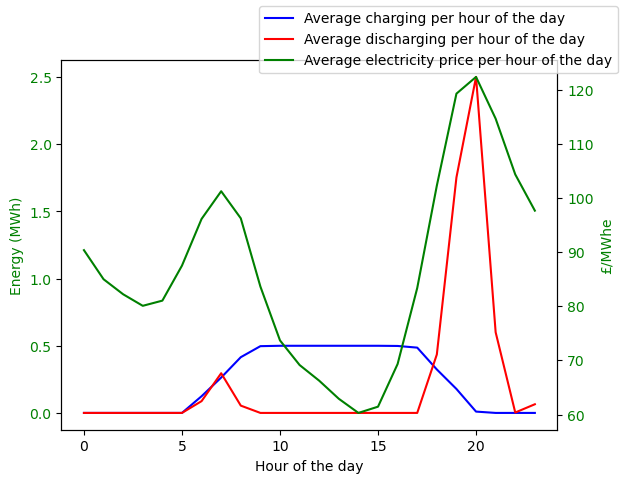

In [36]:
fig, ax1 = plt.subplots()
ax1.plot([average_charging_per_hour_of_the_day[t] for t in range(24)], label='Average charging per hour of the day', color = 'b')
ax1.plot([average_discharging_per_hour_of_the_day[t] for t in range(24)], label='Average discharging per hour of the day', color = 'r')
ax1.set_xlabel("Hour of the day")
ax1.set_ylabel("Energy (MWh)", color = 'g')
ax1.tick_params(axis='y', labelcolor = 'g')

ax2 = ax1.twinx()
ax2.plot([average_electricity_price_per_hour_of_the_day[t] for t in range(24)], label = "Average electricity price per hour of the day", color = 'g')
ax2.set_ylabel("£/MWhe", color = 'g')
ax2.tick_params(axis='y', labelcolor = 'g')

# Show the plot
fig.legend()
plt.show()

